In [190]:
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import numpy as np
import sklearn
import mne_icalabel
import matplotlib.pyplot as plt
from braindecode.models.util import models_dict
from braindecode.models import EEGInceptionERP
from braindecode import EEGClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch

Open BDF file

In [191]:
raw = mne.io.read_raw_bdf("/Users/hrakol/Desktop/Thesis EEG/user_18_session_1.bdf", preload = True)

Extracting EDF parameters from /Users/hrakol/Desktop/Thesis EEG/user_18_session_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 401407  =      0.000 ...   196.000 secs...


Get Events through trigger(Status) channel

In [192]:
events = mne.find_events(raw, stim_channel = "Status", shortest_event = 1)

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15 events found on stim channel Status
Event IDs: [2]


Remove unused BioSemi channels

In [193]:
keep_ch = raw.ch_names[:32] + ["Status"]
raw = raw.pick(keep_ch)

Deleta data recorded before the experiment starts

In [194]:
first_stim = events[events[:, 2] == 2][0, 0] #find the first code 2 event in frames
last_stim = events[events[:, 2] == 2][-1, 0]
first_stim_time = raw.times[first_stim]
last_stim_time = raw.times[last_stim]
start_time = max(2.0, first_stim_time - 2.0)
end_time = min(raw.times[-1], last_stim_time  + 1.5  # stim duration
                                              + 3.0  # extra time until resting state screen closes
                                              + 0.3) # extra time to be sure    

raw.crop(tmin = start_time, tmax = end_time)

<RawEDF | user_18_session_1.bdf, 33 x 350212 (171.0 s), ~88.2 MB, data loaded>

Drift removal

In [195]:
filt_raw = raw.copy().filter(l_freq = 1.0, h_freq = 100.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished


Random state

Spectrum Analysis(Remove power line noise)

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


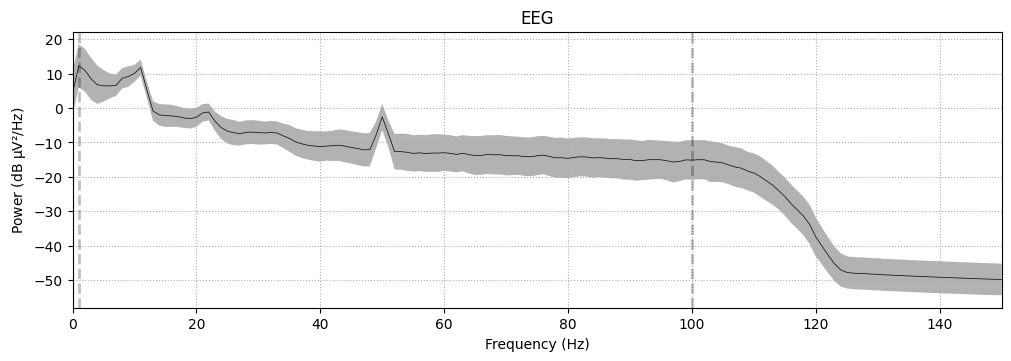

In [196]:
fig = filt_raw.compute_psd(fmax = 150).plot(
        average = True, amplitude = False, picks = "data", exclude = "bads"
)

Power line noise Ratio check

In [197]:
psd = filt_raw.compute_psd(fmin = 40, fmax = 60)
freqs = psd.freqs
psd_data = psd.get_data()

#Get index for 50Hz data and neighboring frequencies 
idx_50 = np.argmin(np.abs(freqs - 50))
idx_left = np.where((freqs >= 40) & (freqs < 48))[0]
idx_right = np.where((freqs > 52) & (freqs <= 60))[0]

#Get mean power for the frequencies and calculate the ratio: 50Hz / neighbors
power_50 = psd_data[:, idx_50].mean()
power_neighbors = np.concatenate([psd_data[:, idx_left], psd_data[:, idx_right]], axis = 1).mean()
power_ratio = power_50 / (power_neighbors + 1e-15) #No Divide by 0 error

if power_ratio > 2 :
    filt_raw.notch_filter(freqs = (50,100,150), method = "spectrum_fit")


Effective window size : 1.000 (s)


Filtering raw data in 1 contiguous segment
Removed notch frequencies (Hz):
     50.00 : 1056 windows
    100.00 : 1056 windows
    150.00 : 1056 windows


Filtering raw data in 1 contiguous segment
Removed notch frequencies (Hz):
     50.00 : 1056 windows
    100.00 : 1056 windows
    150.00 : 1056 windows
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


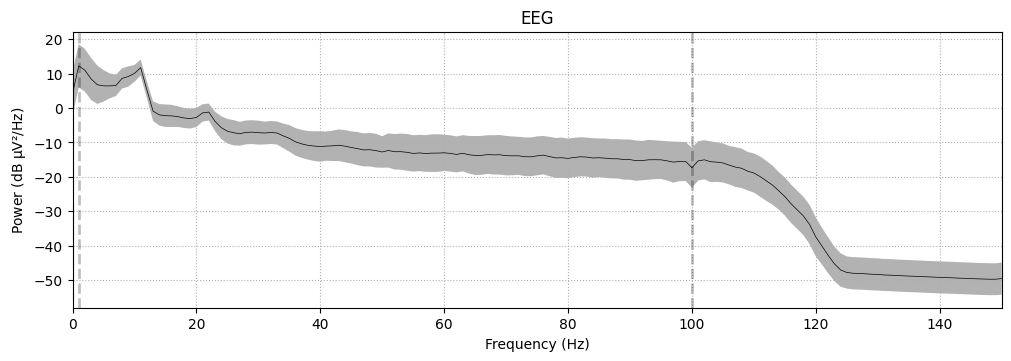

In [198]:
filt_raw.notch_filter(freqs = (50, 100, 150), method = "spectrum_fit")
fig = filt_raw.compute_psd(fmax = 150).plot(
        average = True, amplitude = False, picks = "data", exclude = "bads"
)

Set up CAR and filter to get ready for icalabel

In [199]:
filt_raw = filt_raw.set_eeg_reference("average", projection = False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Artifact removal 

In [200]:
montage = mne.channels.make_standard_montage(kind = "biosemi32")

rename_dict = dict(zip(filt_raw.ch_names, montage.ch_names)) #rename raw_data channel names to match the 
filt_raw.rename_channels(rename_dict)                        #biosemi32 channel names

filt_raw.set_montage(montage)

<RawEDF | user_18_session_1.bdf, 33 x 350212 (171.0 s), ~88.2 MB, data loaded>

In [201]:
ica = ICA(n_components = 0.999, max_iter = "auto", method = "infomax", fit_params = dict(extended = True), random_state = 18) # 0.999 to show variance
ica.fit(filt_raw)
ica

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 28 components
Computing Extended Infomax ICA
Fitting ICA took 20.2s.


/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/utils/linalg.py:243: RuntimeWarning: divide by zero encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/utils/linalg.py:243: RuntimeWarning: overflow encountered in matmul
  return (u @ vh[:rank]).conj().T
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/utils/linalg.py:243: RuntimeWarning: invalid value encountered in matmul
  return (u @ vh[:rank]).conj().T


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,156 iterations on raw data (350212 samples)
ICA components,28
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


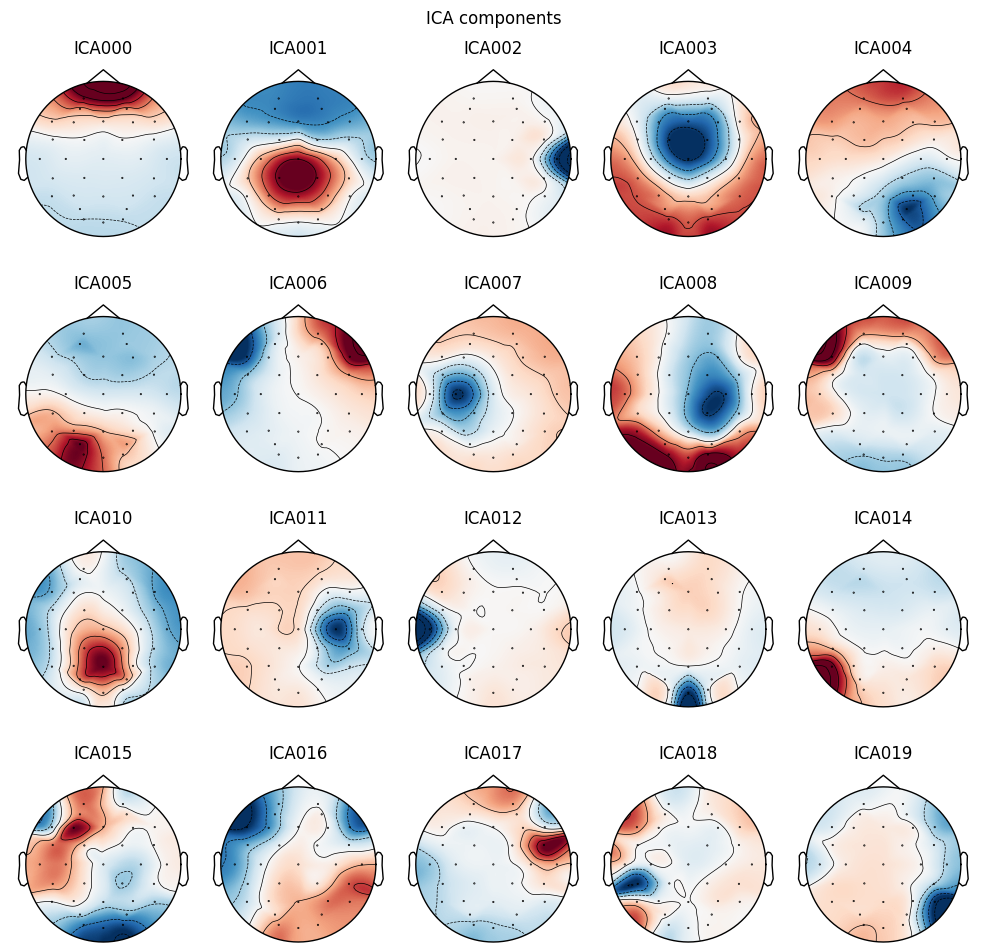

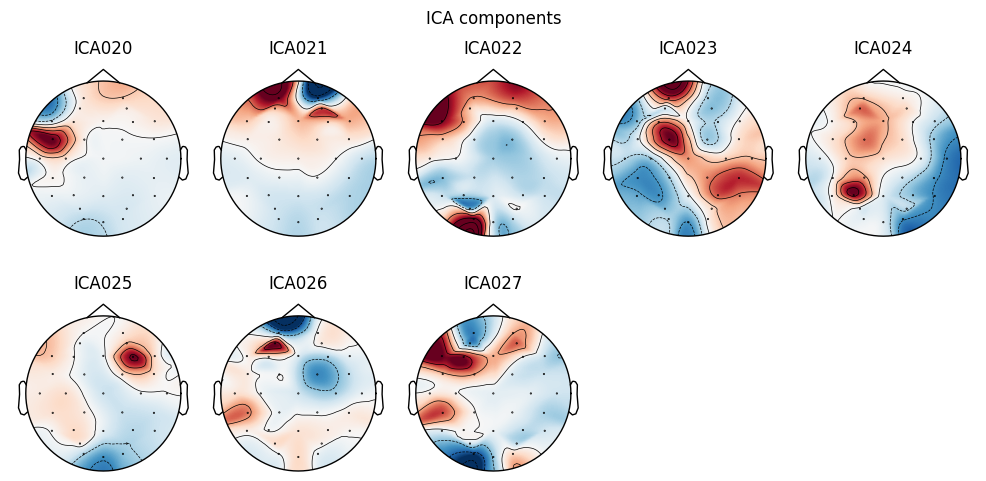

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 8 Axes>]

In [202]:
ica.plot_components()

Creating RawArray with float64 data, n_channels=28, n_times=350212
    Range : 31925 ... 382136 =     15.588 ...   186.590 secs
Ready.


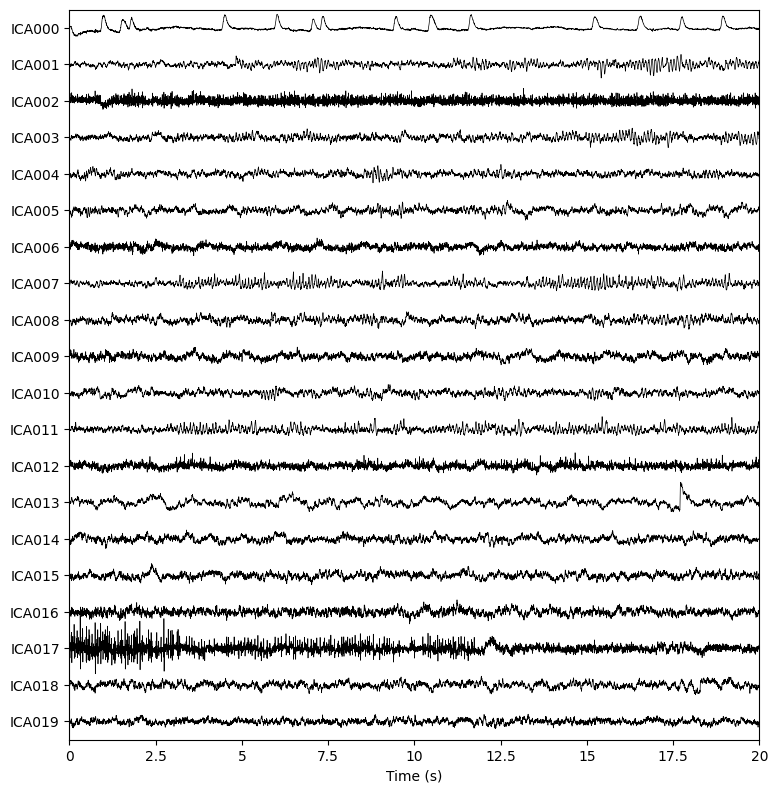

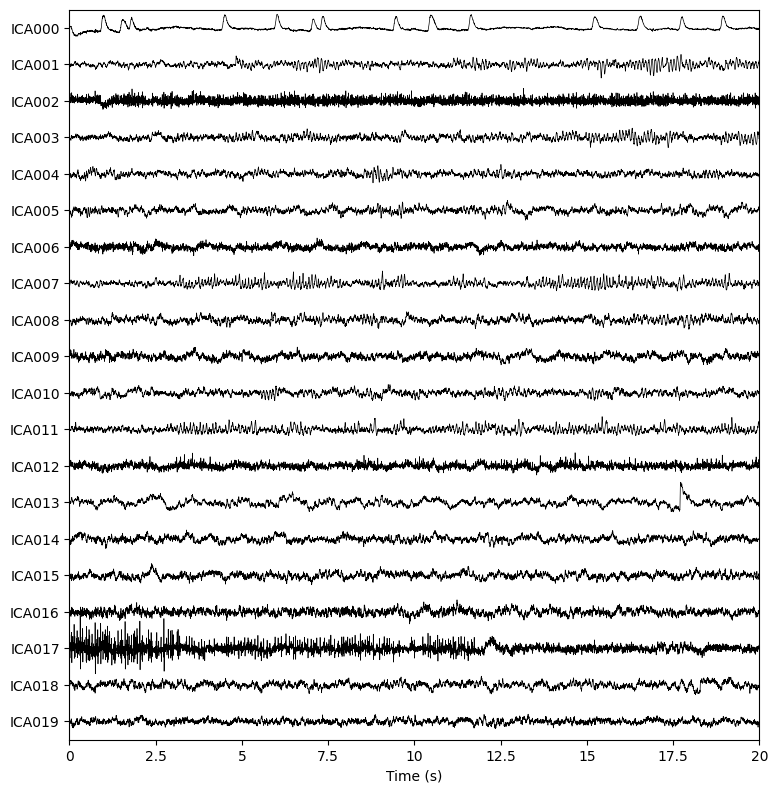

In [203]:
ica.plot_sources(filt_raw, show_scrollbars = False, show = True)

EOG artifacts with Fp reference

In [204]:
eog_inds, eog_scores = ica.find_bads_eog(filt_raw, ch_name = ["Fp1", "Fp2"])
if eog_inds:
    eog_inds = [int(x) for x in eog_inds]

Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


ICALABEL to label ica components

In [205]:
ica_labels = mne_icalabel.label_components(filt_raw, ica, method = "iclabel")

/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: divide by zero encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: overflow encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne_icalabel/iclabel/features.py:135: RuntimeWarning: invalid value encountered in matmul
  weights = (u * s) @ v
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _co

In [206]:
print(ica_labels["labels"])
print(ica_labels["y_pred_proba"])

['eye blink', 'brain', 'muscle artifact', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'other', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'other', 'other', 'other', 'brain', 'other', 'eye blink', 'other', 'brain', 'brain', 'brain', 'other', 'other']
[0.9982884  0.99999946 0.9999914  0.99995947 0.9987562  0.9978331
 0.91966194 0.999485   0.9668891  0.6821001  0.99842685 0.99806553
 0.5670254  0.6076978  0.77789176 0.94761014 0.6158278  0.93834317
 0.623948   0.9227654  0.81815684 0.91127574 0.9024246  0.98291713
 0.6522301  0.65826356 0.69362354 0.81019056]


Compare EOG and ICALABEL results for eye-blink artifacts

In [207]:
iclabel_eye_components = [i for i, label in enumerate(ica_labels["labels"]) if label == "eye blink"]
overlap = set(iclabel_eye_components) & set(eog_inds)
only_iclabel = set(iclabel_eye_components) - set(eog_inds)
only_find_bads = set(eog_inds) - set(iclabel_eye_components)

print("overlap:", overlap)
print("Only in ICLabel:", only_iclabel)
print("Only in find_bads_eog:", only_find_bads)

overlap: {0}
Only in ICLabel: {12, 21, 6}
Only in find_bads_eog: set()


Find correct eog components

In [208]:
if bool(overlap) == 0:
    if eog_inds:
        eog_components = eog_inds
    else:
        eog_components = iclabel_eye_components
else:
    eog_components = list(overlap)

Artifact components to exclude

In [209]:
exclude_comp =  [i for i, label in enumerate(ica_labels["labels"]) if label not in ["brain", "other", "eye blink"]] + eog_components
exclude_comp.sort()

Plot filtered data without the excluded components

Applying ICA to Raw instance


    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/preprocessing/ica.py:2370: RuntimeWarning: divide by zero encountered in matmul
  mixing = pca_components.T @ mixing
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/preprocessing/ica.py:2370: RuntimeWarning: overflow encountered in matmul
  mixing = pca_components.T @ mixing
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/mne/preprocessing/ica.py:2370: RuntimeWarning: invalid value encountered in matmul
  mixing = pca_components.T @ mixing


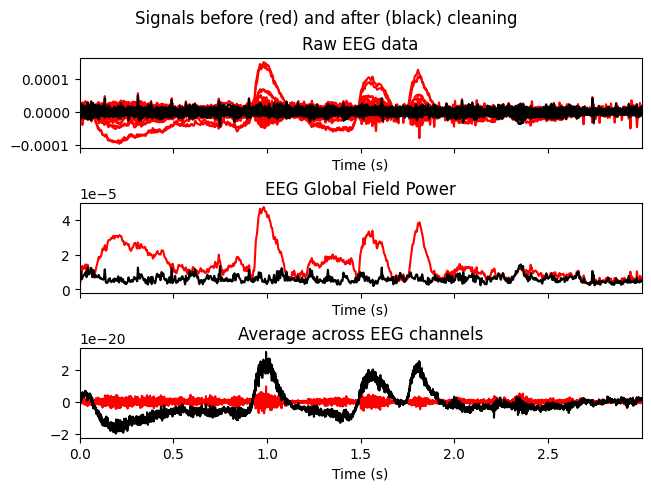

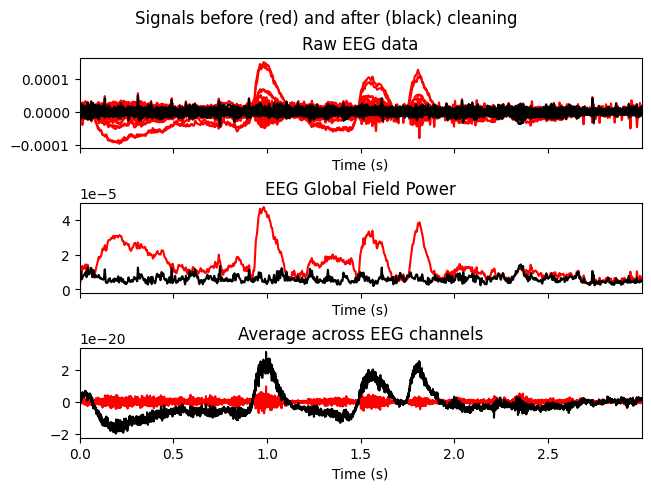

In [210]:
ica.plot_overlay(filt_raw, exclude = exclude_comp, picks = "eeg") # PROBLEM WITH AVERAGE ACROSS EEG CHANNELS

Resample

In [211]:
filt_raw.filter(l_freq = 0,h_freq = 70.0)
filt_raw.resample(256)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 387 samples (0.189 s)

15 events found on stim channel Status
Event IDs: [2]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished


15 events found on stim channel Status
Event IDs: [2]


<RawEDF | user_18_session_1.bdf, 33 x 43776 (171.0 s), ~11.1 MB, data loaded>

Remake events variable

In [212]:
events = mne.find_events(filt_raw, stim_channel = "Status", shortest_event = 1)

15 events found on stim channel Status
Event IDs: [2]


Epoch

In [213]:
epochs = mne.Epochs(filt_raw, events = events, tmin = -0.3, tmax = 2.5, baseline = (None, 0), preload = True)

Not setting metadata
15 matching events found
Setting baseline interval to [-0.30078125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 718 original time points ...
0 bad epochs dropped


In [214]:
print(epochs)

<Epochs | 15 events (all good), -0.301 – 2.5 s (baseline -0.301 – 0 s), ~2.8 MB, data loaded,
 '2': 15>


Feature Extraction

In [215]:
print(f'All the Braindecode models:\n{list(models_dict.keys())}')

All the Braindecode models:
['ATCNet', 'Deep4Net', 'DeepSleepNet', 'EEGConformer', 'EEGITNet', 'EEGInception', 'EEGInceptionERP', 'EEGInceptionMI', 'EEGNetv1', 'EEGNetv4', 'EEGResNet', 'HybridNet', 'ShallowFBCSPNet', 'SleepStagerBlanco2020', 'SleepStagerChambon2018', 'SleepStagerEldele2021', 'TCN', 'TIDNet', 'USleep']


EEGInceptionERP

Prepare Data

In [216]:
x = epochs.get_data() #shape: (n_epochs, n_channels, n_times)
y = epochs.events[:, -1] #labels

In [217]:
n_classes = len(np.unique(y))  # number of output classes
n_channels = x.shape[1]
#input_time_length = x.shape[2]  # number of time points per trial

model = EEGInceptionERP(
    in_channels = n_channels,
    n_classes = n_classes
)

/Users/hrakol/Library/Python/3.9/lib/python/site-packages/braindecode/models/base.py:23: UserWarning: EEGInceptionERP: 'in_channels' is depreciated. Use 'n_chans' instead.
  warnings.warn(
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/braindecode/models/base.py:23: UserWarning: EEGInceptionERP: 'n_classes' is depreciated. Use 'n_outputs' instead.
  warnings.warn(
/Users/hrakol/Library/Python/3.9/lib/python/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [218]:
print(x.shape)

(15, 33, 718)


Train model

In [219]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 18)

# Wrap into EEGClassifier
clf = EEGClassifier(
    model,
    criterion = torch.nn.CrossEntropyLoss,
    optimizer = torch.optim.Adam,
    train_split = None,
    optimizer__lr = 1e-3,
    batch_size = 16,
    max_epochs = 20,
    device = device
)

# Fit model
clf.fit(x_train, y_train)

NameError: name 'device' is not defined

Evaluate model

In [ ]:
y_pred = clf.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.2%}")

Export to CSV file 